In [2]:
%pycache
import tensorflow as tf
tf.compat.v1.enable_eager_execution()

UsageError: Line magic function `%pycache` not found.


In [3]:
import tensorflow as tf
import pandas as pd
import io
import re
import csv
import json
import numpy as np
from tqdm import tqdm
import math
import ast
from tensorflow.keras import datasets, layers, models
import seaborn as sns
from keras import backend as K
from progressbar import ProgressBar
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import sklearn.preprocessing as preprocessing
from random import randrange

from plot_figures import save_model


pbar = ProgressBar()
tqdm.pandas()

Using TensorFlow backend.


In [4]:
max_blocks = 37 #(36 + 1 FC layer at the end)
#max_blocks = 36

nb_param =13
#nb_param =12

DATASET_SIZE = 150894
train_size = int(0.90 * DATASET_SIZE)
test_size = int(0.10 * DATASET_SIZE)

BATCH_SIZE = 2048
SHUFFLE_BUFFER_SIZE = 100


nb_training_batches = train_size //BATCH_SIZE +1
nb_test_batches = test_size //BATCH_SIZE +1

 # Load dataset (nb_batch, nb_max_blocks, nb_features + nb_hw_param)


In [5]:

path_raw_val = '/Users/roxanefischer/Desktop/single_path_nas/single-path-nas/HAS/data/parsed_nondups_val1.csv'
path_raw_train = '/Users/roxanefischer/Desktop/single_path_nas/single-path-nas/HAS/data/parsed_nondups_train1.csv'


path_processed_val = '/Users/roxanefischer/Desktop/single_path_nas/single-path-nas/HAS/val_hw_13.csv'
path_processed_train = '/Users/roxanefischer/Desktop/single_path_nas/single-path-nas/HAS/train_hw_13.csv'

In [6]:

def from_np_array(array_string):
    array_string = ','.join(array_string.replace('[ ', '[').split())
    return np.asarray(ast.literal_eval(array_string))


val= pd.read_csv(path_processed_val,converters={'NN_dataframe': from_np_array})
train = pd.read_csv(path_processed_train,converters={'NN_dataframe': from_np_array})



# Complete to zeros (max shape = 36 +1 FC)

### Store copy with blocks **different** shapes

In [7]:
val_diff = val.copy()
train_diff = train.copy()

In [8]:
#%pycache

def add_zero_blocks(arr):
    zero_blocks = np.zeros(( max_blocks-arr.shape[0],arr.shape[1]))
    return np.append(arr, zero_blocks, axis=0)

val['NN_dataframe']= val['NN_dataframe'].apply(lambda x : add_zero_blocks(x))
train['NN_dataframe']= train['NN_dataframe'].apply(lambda x : add_zero_blocks(x))





# Get X_train, Y-train, X_test, y_test


In [9]:
# To retrieve y_train / y_test

train_hw = pd.read_csv(path_raw_train)
val_hw = pd.read_csv(path_raw_val)

y_train = np.array(train_hw["total_power"].tolist())
y_train=y_train.reshape(y_train.shape[0],-1)

y_val = np.array(val_hw["total_power"].tolist())
y_val=y_val.reshape(y_val.shape[0],-1)


### Inputs with different shapes

In [10]:
#%pycache
X_train_diff=np.array(train_diff['NN_dataframe'].tolist())
X_val_diff = np.array(val_diff['NN_dataframe'].tolist())

### Same shapes

In [11]:
#%pycache
X_train =np.array(train['NN_dataframe'].tolist())
X_val = np.array(val['NN_dataframe'].tolist())

In [12]:
X_train.shape

(137090, 37, 13)

In [13]:
X_val.shape

(13804, 37, 13)

### Normalize (same shapes)

In [14]:
#%pycache

#Reshape
train_reshape= X_train.reshape(X_train.shape[0], -1)
val_reshape= X_val.reshape(X_val.shape[0], -1)

# Process
scaler = preprocessing.StandardScaler().fit(train_reshape)
train_scaled= scaler.transform(train_reshape)
val_scaled = scaler.transform(val_reshape)

#Re-reshape
X_train_norm= train_scaled.reshape(X_train.shape)
X_val_norm= val_scaled.reshape(X_val.shape)


# Visualize

In [15]:

values_to_keep = ['FLOPS','weights','tensor_in','tensor_out','hidden_dim','k2', 'skip']
HW_param =  ['mac_num','mac_array_num','total_mac','data_bits','sram_size','max_filter_size']



### Not Normalized (same shape : 37 x 13)

In [18]:

pd.DataFrame(X_train[0],columns = values_to_keep +HW_param)



,FLOPS,weights,tensor_in,tensor_out,hidden_dim,k2,skip,mac_num,mac_array_num,total_mac,data_bits,sram_size,max_filter_size
0,6096384.0,252.0,150528.0,112896.0,3.0,9.0,0.0,118.0,2.0,236.0,256.0,179968.0,2048.0
1,2032128.0,90.0,112896.0,112896.0,9.0,9.0,0.0,118.0,2.0,236.0,256.0,179968.0,2048.0
2,1806336.0,80.0,112896.0,100352.0,9.0,1.0,0.0,118.0,2.0,236.0,256.0,179968.0,2048.0
3,55996416.0,2263.0,100352.0,388864.0,8.0,9.0,0.0,118.0,2.0,236.0,256.0,179968.0,2048.0
4,251983872.0,10333.0,388864.0,514304.0,124.0,9.0,0.0,118.0,2.0,236.0,256.0,179968.0,2048.0
5,114689792.0,8414.0,514304.0,156800.0,82.0,9.0,0.0,118.0,2.0,236.0,256.0,179968.0,2048.0
6,68364800.0,11150.0,156800.0,156800.0,100.0,9.0,0.0,118.0,2.0,236.0,256.0,179968.0,2048.0
7,89689600.0,14584.0,156800.0,263424.0,100.0,9.0,0.0,118.0,2.0,236.0,256.0,179968.0,2048.0
8,241823232.0,38607.0,263424.0,159936.0,84.0,9.0,0.0,118.0,2.0,236.0,256.0,179968.0,2048.0
9,74850048.0,12195.0,159936.0,178752.0,102.0,9.0,0.0,118.0,2.0,236.0,256.0,179968.0,2048.0


### Normalized (same shape 37 x 13)

In [17]:
pd.DataFrame(X_train_norm[0], columns=values_to_keep +HW_param)

,FLOPS,weights,tensor_in,tensor_out,hidden_dim,k2,skip,mac_num,mac_array_num,total_mac,data_bits,sram_size,max_filter_size
0,-1.732985,-1.732985,0.000000,-1.732985,0.000000,0.000000,0.000000,0.824946,-0.456088,-0.230160,-0.580558,0.680540,0.462420
1,-1.732985,-1.732985,-1.732985,-1.732985,-1.732985,0.000000,0.000000,0.824946,-0.456088,-0.230160,-0.580558,0.680540,0.462420
2,-1.628362,-1.644735,-1.732985,-1.763051,-1.732985,0.000000,0.000000,0.824946,-0.456088,-0.230160,-0.580558,0.680540,0.462420
3,-0.750847,-0.855229,-1.763051,0.886909,-1.475069,-0.486017,-0.130483,0.824946,-0.456088,-0.230160,-0.580558,0.680540,0.462420
4,0.180013,0.000068,0.886909,1.675839,0.277945,-0.492460,-0.766784,0.824946,-0.456088,-0.230160,-0.580558,0.680540,0.462420
5,-0.082907,-0.123850,1.675839,-0.022976,-0.198359,-0.465854,-0.808023,0.824946,-0.456088,-0.230160,-0.580558,0.680540,0.462420
6,-0.169837,-0.105747,-0.022976,0.084993,-0.124414,-0.503850,-0.829639,0.824946,-0.456088,-0.230160,-0.580558,0.680540,0.462420
7,-0.090149,-0.111671,0.084993,0.779885,-0.202772,-0.510258,-0.782176,0.824946,-0.456088,-0.230160,-0.580558,0.680540,0.462420
8,0.313116,0.011835,0.779885,0.352331,-0.397104,-0.546979,-0.736737,0.824946,-0.456088,-0.230160,-0.580558,0.680540,0.462420
9,-0.098581,-0.146394,0.352331,0.573374,-0.313967,-0.456950,-0.692156,0.824946,-0.456088,-0.230160,-0.580558,0.680540,0.462420


----------
# Define tf.Dataset

### 36 x Normalized

In [17]:
#%pycache

#define dataset
train_dataset_norm = tf.data.Dataset.from_tensor_slices((X_train_norm, y_train))
test_dataset_norm = tf.data.Dataset.from_tensor_slices((X_val_norm, y_val))


#### Shuffle train/test dataset

In [18]:
#%pycache
# Mix between train/test (mix networks)

full_dataset = train_dataset_norm.concatenate(test_dataset_norm)
full_dataset = full_dataset.shuffle(SHUFFLE_BUFFER_SIZE)
train_dataset_norm = full_dataset.take(train_size)
test_dataset_norm = full_dataset.skip(train_size)
test_dataset_norm = test_dataset_norm.take(test_size)

#### Take batches

In [19]:
## shuffle batch
train_dataset_norm = train_dataset_norm.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
test_dataset_norm = test_dataset_norm.batch(BATCH_SIZE)

### 36 x Unormalized


In [20]:
#define dataset
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))

# shuffle batch
train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

### Small dataset 

In [21]:

mini_batches = 7

train_dataset_small =train_dataset_norm.take(mini_batches)
test_dataset_small =test_dataset_norm.take(mini_batches)



 ### !!! Not used :  Test on Dynamic Batchsize !!!!!

In [22]:
%pycache
image_op = tf.placeholder(tf.float32, shape=[None, None, nb_param], name='input_image')
image_op : X_train_diff
image_o = tf.placeholder(tf.float32, shape=[None, None, nb_param], name='input_image')
image_o : X_val_diff

#BATCH_TRY = tf.placeholder(tf.int64)
BATCH_TRY = 2
train_dataset_diff = tf.data.Dataset.from_generator(lambda: zip(image_op, y_train), output_types=(tf.float64, tf.float64), output_shapes=( (None,nb_param), (1,)  )  )
test_dataset_diff = tf.data.Dataset.from_generator(lambda: zip(image_o, y_val), output_types=(tf.float64, tf.float64), output_shapes=( (None,nb_param), (1,)  )     )
train_dataset_diff = train_dataset_diff.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_TRY)
test_dataset_diff = test_dataset_diff.batch(BATCH_TRY)

import tensorflow_datasets as tfds
graph = tf.Graph()
with tf.Session(graph=graph) as sess:
    for example in tfds.as_numpy(train_dataset_diff):
        print(example)
        break

UsageError: Line magic function `%pycache` not found.


-------------

# MODELS

In [23]:
def loss(target_power, predicted_power):
  return tf.math.abs((target_power - predicted_power)/target_power)

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=nb_training_batches*2,
    decay_rate=0.95)


optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
#initializer = tf.keras.initializers.GlorotNormal()

# Full CONV 1D

In [34]:
model_conv1D= tf.keras.Sequential([
     layers.Conv1D(32, (3), activation='relu', padding="same"),
     #layers.Dropout(0.1),
     layers.Conv1D(32*2, (1), activation='relu', padding="same"),
     #layers.Dropout(0.1),
     layers.Conv1D(32, (3), activation='relu', padding="same"),
     #layers.Dropout(0.1),
     layers.Conv1D(1, (3), activation='relu', padding="same"),
     layers.Lambda( lambda x: K.sum(x, axis=1)),
 ])


model_conv1D.compile(optimizer=optimizer,
              loss=loss)
history_conv1D = model_conv1D.fit(train_dataset_norm,
          validation_data=(test_dataset_norm),
          epochs=5,
          verbose=1,
          #callbacks=[TestCallback((test_dataset)) ] )
)



If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Epoch 1/5
67/67 [==============================] - 24s 357ms/step - loss: 0.6620 - val_loss: 0.0000e+00
Epoch 2/5
67/67 [==============================] - 19s 285ms/step - loss: 0.5160 - val_loss: 0.5062
Epoch 3/5
67/67 [==============================] - 22s 334ms/step - loss: 0.4379 - val_loss: 0.4378
Epoch 4/5
67/67 [==============================] - 23s 336ms/step - loss: 0.4024 - val_loss: 0.4147
Epoch 5/5
67/67 [==============================] - 19s 287ms/step - loss: 0.3700 - val_loss: 0.3840


# Save model informations


9384
pred : [[5.0996165]]
true : [5.09129944]
loss : [[0.00163359]]

612
pred : [[31.644941]]
true : [41.42684727]
loss : [[0.2361248]]

6875
pred : [[15.443963]]
true : [34.34221583]
loss : [[0.55029218]]

9505
pred : [[5.168586]]
true : [5.18722576]
loss : [[0.00359344]]

207
pred : [[34.20785]]
true : [40.78468945]
loss : [[0.16125752]]

680
pred : [[51.83076]]
true : [54.53944108]
loss : [[0.04966461]]

11458
pred : [[26.97362]]
true : [11.67349292]
loss : [[1.31067253]]

10444
pred : [[19.452562]]
true : [13.34666315]
loss : [[0.45748507]]

10346
pred : [[34.83138]]
true : [21.46171347]
loss : [[0.62295424]]

7845
pred : [[53.35866]]
true : [65.40522205]
loss : [[0.18418346]]

Mean loss on predictions : 0.35778614569097755
No Middle Value Predictions
No High Value Predictions


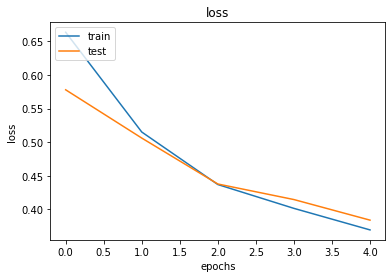

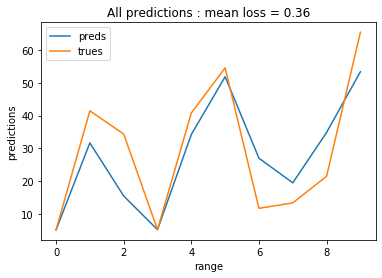

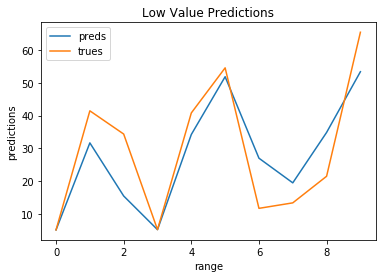

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [36]:

nb_predictions = 10
max_val_loss=0.50
nb_final_epochs_for_mean = 3 

save = True
path = "/Users/roxanefischer/Desktop/single_path_nas/single-path-nas/HAS/results_best_models/Conv1D"
#model = model_conv1D
name = f'{model.count_params()}_param'
X_list = [X_val_norm]
history = history_conv1D

#model = full_model
#X_list = [X_val_hw_param_norm, X_val_nn_norm]

save_model(path=path, model= model, history=history, X_list=X_list, y=y_val, name=name, nb_predictions = nb_predictions, max_val_loss=max_val_loss, nb_final_epochs_for_mean = nb_final_epochs_for_mean , save= save)

# Unormalized Data

In [26]:


lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-1,
    decay_steps=15*67,
    decay_rate=0.9)

model_unormed= tf.keras.Sequential([
     layers.Conv1D(32, (3), activation='relu', padding="same"),
     layers.Dropout(0.1),
     layers.Conv1D(32*2, (1), activation='relu', padding="same"),
     layers.Dropout(0.1),
     layers.Conv1D(32, (3), activation='relu', padding="same"),
     layers.Dropout(0.1),
     layers.Conv1D(1, (3), activation='relu', padding="same"),
     layers.Lambda( lambda x: K.sum(x, axis=1)),
 ])


model_unormed.compile(optimizer=optimizer,
              loss=loss)
history_unormed = model_unormed.fit(train_dataset,
          validation_data=(test_dataset),
          epochs=1,
          verbose=1,
          #callbacks=[TestCallback((test_dataset)) ] )
)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

67/67 [==============================] - 47s 697ms/step - loss: 26930.4928 - val_loss: 0.0000e+00


# Test Fully connected

In [27]:
model_fc = tf.keras.Sequential([
     layers.Conv1D(128,3,activation='relu', input_shape=(37,13)),
     layers.Dense(4, activation='relu'),
     layers.Dense(8, activation='relu'),
     #layers.Dense(32, activation='relu'),
     #layers.Dense(32, activation='relu'),
     #layers.Dense(32, activation='relu'),
     #layers.Dense(32, activation='relu'),
     #layers.Dense(32, activation='relu'),
     #layers.Dense(32, activation='relu'),
     layers.Dense(1, activation='linear')
 ])

In [28]:

def loss(target_power, predicted_power):
  return tf.math.abs((target_power - predicted_power)/target_power)

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=nb_training_batches*2,
    decay_rate=0.95)



model_fc.compile(optimizer=optimizer, loss=loss)
# hw = model_hw.fit(train_dataset_hw,
#           validation_data=(test_dataset_hw),
#           epochs=2,
#           verbose=1)

fc = model_fc.fit(train_dataset_small,
          validation_data=(test_dataset_small),
          epochs=3,
          verbose=1)

Epoch 1/30
7/7 [==============================] - 8s 1s/step - loss: 0.8997 - val_loss: 0.0000e+00
Epoch 2/30
7/7 [==============================] - 5s 741ms/step - loss: 0.7355 - val_loss: 0.6793
Epoch 3/30
7/7 [==============================] - 5s 754ms/step - loss: 0.6870 - val_loss: 0.6887
Epoch 4/30
7/7 [==============================] - 5s 686ms/step - loss: 0.6470 - val_loss: 0.7121
Epoch 5/30
7/7 [==============================] - 5s 777ms/step - loss: 0.6401 - val_loss: 0.6681
Epoch 6/30
7/7 [==============================] - 5s 701ms/step - loss: 0.6179 - val_loss: 0.6345
Epoch 7/30
7/7 [==============================] - 5s 785ms/step - loss: 0.6050 - val_loss: 0.6453
Epoch 8/30
7/7 [==============================] - 5s 740ms/step - loss: 0.5948 - val_loss: 0.6341
Epoch 9/30
7/7 [==============================] - 6s 809ms/step - loss: 0.5861 - val_loss: 0.6261
Epoch 10/30
7/7 [==============================] - 5s 777ms/step - loss: 0.5778 - val_loss: 0.6213
Epoch 11/30
7/7 [=

In [30]:
name = f'{model_fc.count_params()}_param'
nb_predictions = 10
max_val_loss=0.30
nb_final_epochs_for_mean = 3 
save = False

path = "/Users/roxanefischer/Desktop/single_path_nas/single-path-nas/HAS/results_best_models/FC"
model = model_fc
X_list = [X_val_norm]
history = fc


save_model(path=path, model= model, history=history, X_list=X_list, y=y_val, name=name, nb_predictions = nb_predictions, max_val_loss=max_val_loss, nb_final_epochs_for_mean = nb_final_epochs_for_mean , save= save)